# Learn how to play with ER/NR bands

Tunnell, Feburary 2016

This tutorial describes how to draw the ER and NR bands to determine seperation.

The following line just runs our standard code for every analysis.  You can change 'run' to 'load' to see what is in there.

In [1]:
%matplotlib inline
%run boiler_plate.py
import hax  # rootpy raises a warning, but ignore
hax.init()

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Load data

Here are the sources we have:

In [3]:
hax.runs.datasets['source'].unique()

array(['LED', 'Cs137', 'Background', 'Other', 'Th232', 'Co60', 'AmBe',
       'Dark Matter', 'Co57'], dtype=object)

In [4]:
datasets_nr = ['xe100_110210_1100', 'xe100_110210_1412', 'xe100_110211_0532']
datasets_er = 'xe100_1112AA_1648' #np.append(datasets('Co60'), datasets('Th232'))

## Cuts

Here are the cuts

In [ ]:
df_nr = hax.minitrees.load(datasets_nr)
df_er = hax.minitrees.load(datasets_er)

def cut(df):
    cut_single_s1 = (df['largest_other_s1'] == 0)
    cut_single_s2 = (df['largest_other_s2'] < 100)
    cut_radius = (np.sqrt(df['x']**2 + df['y']**2) < 12)
    cut_z = (df['z'] < -5) & (df['z'] > -27)
    cut_fiducial = (cut_radius & cut_z)
    cut_energy =  (df['cs1'] > 0) & (df['cs1'] < 40)
    
    return df[cut_energy]# & cut_single_s1 & cut_single_s2 & cut_fiducial]

df_er = cut(df_er)
df_nr = cut(df_nr)

Inspect $(x,y)$

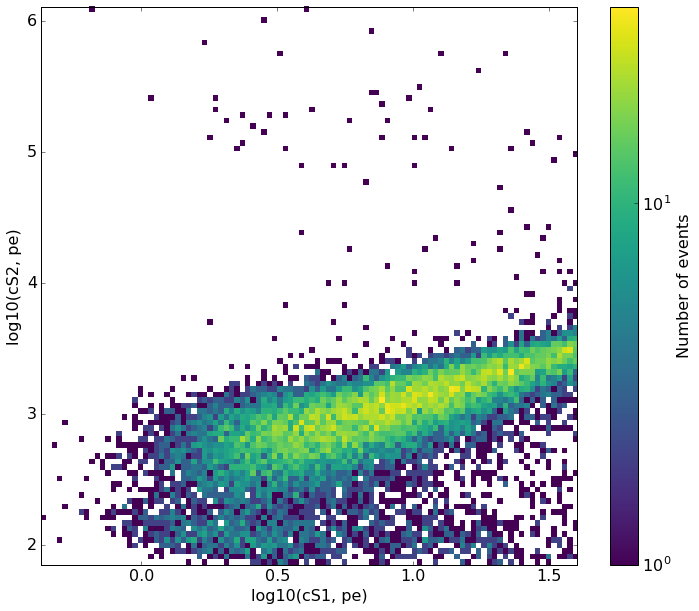

In [28]:
# Make an S1 vs S2 histogram
plt.hist2d(np.log10(df_nr['cs1']), np.log10(df_nr['cs2']),
           bins=100, 
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')
plt.xlabel('log10(cS1, pe)')
plt.ylabel('log10(cS2, pe)')
plt.show()

Inspect $(r,z)$.

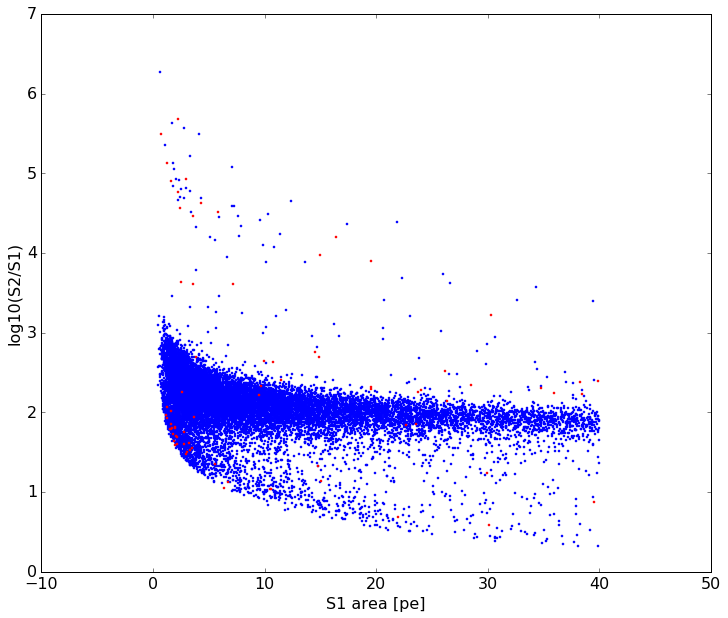

In [29]:
plt.scatter(df_nr['cs1'],
            np.log10(df_nr['cs2']/df_nr['cs1']),
            marker='.',
            s=10,
            color='blue',
            alpha=1)
plt.scatter(df_er['cs1'],
            np.log10(df_er['cs2']/df_er['cs1']),
            marker='.',
            s=10,
            color='red',
            alpha=1)


plt.xlabel('S1 area [pe]')
plt.ylabel('log10(S2/S1)')

plt.show()

In [ ]:
plt.scatter(np.log10(df['cs1']),
            np.log10(df['cs2']),
            marker='.',
            s=10,
            alpha=1)

plt.xlabel('S1 area [pe]')
plt.ylabel('S2 area [pe]')

plt.show()

In [ ]:
df_40kev = df[(df['cs1'] > 50) & (df['cs1'] < 200) & (df['cs2'] > 15000) & (df['cs2'] < 32000)]

plt.scatter(df_40kev['cs1'],
            df_40kev['cs2'], marker='.')
plt.title('40 keV')
#plt.xlim(0, 250) # S1
#plt.ylim(8000, 25000*2) # S2

plt.xlabel('S1 area [pe]')
plt.ylabel('S2 area [pe]')

plt.show()

In [ ]:
print('S1 (40 keV) pe:', df_40kev['cs1'].mean(), '+/-', df_40kev['cs1'].std())
print('S2 (40 keV) pe:', df_40kev['cs2'].mean(), '+/-', df_40kev['cs2'].std())

In [ ]:
print('S1 pe/keV:', df_40kev['cs1'].mean()/40)
print('S2 pe/keV:', df_40kev['cs2'].mean()/40)

In [ ]:
df_peaks = df[(df['cs1'] > 50) & (df['cs1'] < 500) & (df['cs2'] > 15000) & (df['cs2'] < 300e5)]

In [ ]:
# concatenate the two datasets into the final training set
X_train = np.dstack((df_peaks.to_records()['cs1'],
                     df_peaks.to_records()['cs2']))[0]

# fit a Gaussian Mixture Model with two components
clf = mixture.GMM(n_components=3, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(df_peaks['cs1'].min(),
                df_peaks['cs1'].max())
                
y = np.linspace(df_peaks['cs2'].min(),
                df_peaks['cs2'].max())
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, #norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(1, 2, 100))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

In [ ]:
clf.means_

In [ ]:
df_pid = df[(150 < df['s2_area']) & (10000 > df['s2_area'])]
plt.scatter(df_pid['s1_area'], df_pid['pid'], marker='.', alpha=0.1, s=5,
            color='red', label='NR band')
plt.scatter(df_40kev['s1_area'], df_40kev['pid'], marker='.', alpha=1.0, s=5,
            color='blue', label='40 keV $\gamma$')
plt.legend()
plt.xlabel('Corrected S1 [pe]')
plt.ylabel('log10(S2/s1)')
plt.xlim(0, 220)
plt.ylim(1,4)

In [ ]:
df_inspect = df_pid[df_pid['pid'] < 1.0]


In [ ]:
df_40kev['xed'] = df_40kev['dataset_name']

In [ ]:
df_40kev['dataset_name'] = [x[:-11] for x in df_40kev['dataset_name']]

In [ ]:
df_40kev.head()

In [ ]:
def inspect_event(df_event):
    mypax = core.Processor(config_names='XENON100',
                           config_dict={'pax': {
                 'output': ['Plotting.PlotEventSummary'],
                'input_name':   ('/Users/tunnell/XENON/data/xenon100/run_10/%s/%s' % (df_event['dataset_name'],
                                                                                       df_event['xed'])),
                'events_to_process': [df_event['event_number']],          
                'output_name': 'SCREEN'}})

    mypax.run()

In [ ]:
inspect_event(df_40kev.iloc[0])